In [1]:
import aesara.tensor as at
import numpy as np
import pandas as pd
import pymc as pm

In [41]:
# 5 coefficients
# 4 
x = np.array([1, 2, 3, 4, 5])
idx = np.array([[0, 0, 1, 1], [2, 2, 3, 4]])
np.take_along_axis(x[None], idx, axis=1)

array([[1, 1, 2, 2],
       [3, 3, 4, 5]])

In [21]:
np.random.seed(42)
N = 10203
K = 10
n_factors = np.random.randint(3, 64, size=K)
factor_idx = np.random.randint(0, n_factors, size=(N, K))
data = pd.DataFrame(factor_idx, columns=[f"f{i}" for i in range(K)])
opt_factor_idx = factor_idx + np.cumsum([0, *n_factors[:-1]]) # flatten all factors, no hierarcy
opt_factors = np.random.randn(sum(n_factors))

In [22]:
factor_idx

array([[18, 22, 10, ...,  7, 23,  2],
       [21, 52,  1, ..., 20, 32, 11],
       [21, 43, 24, ..., 15, 14, 46],
       ...,
       [29, 31, 10, ...,  6, 14, 30],
       [18, 21,  6, ...,  2, 35, 36],
       [22, 35,  3, ...,  3,  3,  5]])

In [9]:
with pm.Model() as model:
    rng_factors = pm.Normal("factors", size=(sum(n_factors), ))
    factors_contrib = at.take_along_axis(rng_factors[None], opt_factor_idx, axis=1)
    factors_contrib /= factors_contrib.shape[1] ** .5
    factors_logit = factors_contrib.sum(1) * pm.Exponential("factors_std", 1)

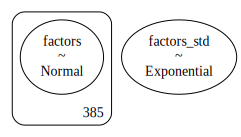

In [10]:
pm.model_to_graphviz(model)

In [133]:
import string

import aesara
import aesara.tensor as at

import numpy as np
import pandas as pd
import scipy.sparse as sp

strings = list(string.ascii_lowercase) + list(string.ascii_uppercase)
strings += [s * 2 for s in strings]
x = np.random.choice(strings, size=10_000)
X = np.asarray(pd.get_dummies(x))
X_sp = sp.csr_matrix(X)
b = np.arange(len(strings), dtype=np.float64) * 1.5
_, idx = np.nonzero(X)
print(X.shape, b.shape, idx.shape)

at_X = at.dmatrix("x")
at_y = at.dvector("y")
at_dot = aesara.function([at_X, at_y], at.dot(at_X, at_y))

at_b = at.dvector("b")
at_idx = at.lvector("idx")
at_take_along = aesara.function([at_b, at_idx], at.take_along_axis(at_b[None], at_idx[None], axis=1))

at_Y = at.dmatrix("Y")
at_X_sp = aesara.sparse.CSR(X_sp.data, X_sp.indices, X_sp.indptr, X_sp.shape)

aet_sparse_dot = aesara.function([at_X_sp, at_Y], aesara.sparse.structured_dot(at_X_sp, at_Y))

(10000, 104) (104,) (10000,)


In [134]:
assert np.allclose(at_take_along(b, idx).squeeze(), at_dot(X, b))
assert np.allclose(at_take_along(b, idx).squeeze(), aet_sparse_dot(X_sp, b[:, None]).squeeze())

In [135]:
%timeit at_dot(X, b)
%timeit at_take_along(b, idx)
%timeit aet_sparse_dot(X_sp, b[:, None])

1.41 ms ± 29.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
50.1 µs ± 598 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
49.4 µs ± 377 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [1]:
import bambi as bmb
import pandas as pd
import arviz as az

df_simple = pd.DataFrame({
    'x': ['A', 'B', 'C'],
    'y': [10, 20, 30],
    'n': [100, 100, 100]
})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

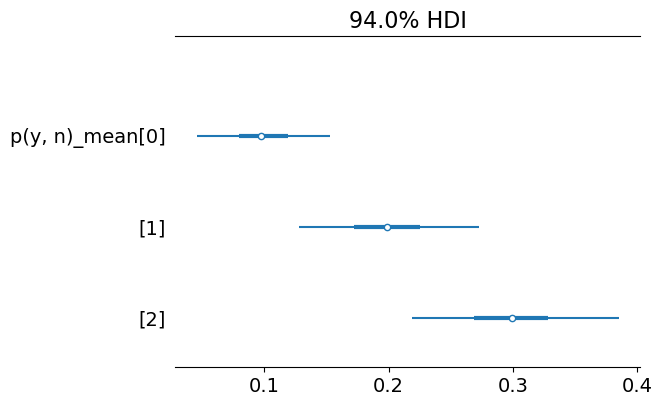

In [2]:
m = bmb.Model('p(y, n) ~ 0 + x', data=df_simple, family='binomial')
idata = m.fit()

m.predict(idata)

az.plot_forest(idata, var_names='p(y, n)_mean', combined=True)

In [4]:
idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 2, draw: 1000, x_dim: 3, p(y, n)_obs: 3)
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * x_dim         (x_dim) <U1 'A' 'B' 'C'
  * p(y, n)_obs   (p(y, n)_obs) int64 0 1 2
Data variables:
    x             (chain, draw, x_dim) float64 -2.315 -1.201 ... -1.229 -0.6792
    p(y, n)_mean  (chain, draw, p(y, n)_obs) float64 0.08988 0.2313 ... 0.3364
Attributes:
    created_at:                  2022-12-13T01:18:17.712454
    arviz_version:               0.12.1
    inference_library:           pymc
    inference_library_version:   4.1.5
    sampling_time:               2.267923355102539
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1

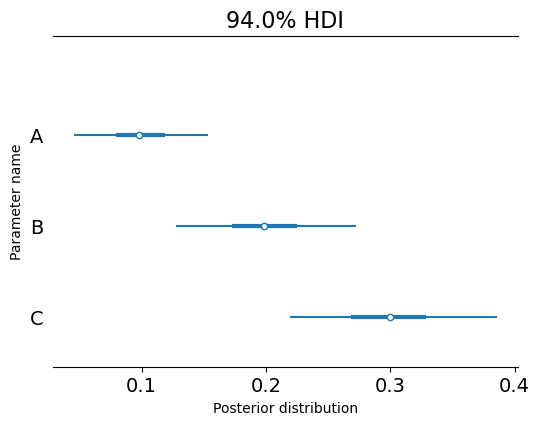

In [15]:
axes = az.plot_forest(idata, var_names='p(y, n)_mean', combined=True)
axes[0].set(yticklabels=["C", "B", "A"], ylabel="Parameter name", xlabel="Posterior distribution");

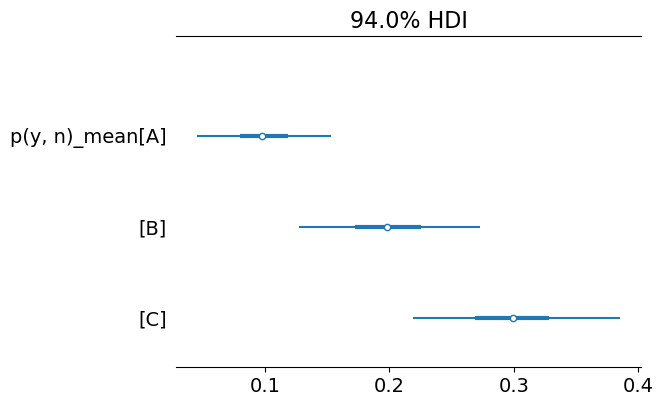

In [17]:
idata.posterior = idata.posterior.assign_coords({"p(y, n)_obs": ["A", "B", "C"]})
az.plot_forest(idata, var_names='p(y, n)_mean', combined=True);